# 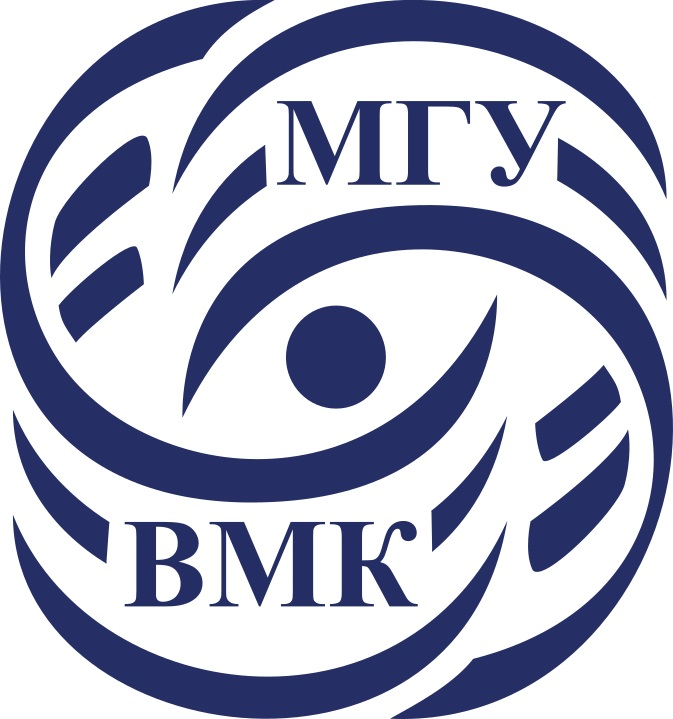

# Машинное обучение. ВМК МГУ

# Практическое задание 9: Случайные леса и отбор признаков
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

__В этом задании вы:__

- Посмотрите, как выращивают случайные леса
- Проверите подвержены ли случайные леса переобучению
- Узнаете базовые методы отбора признаков

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 1.51MB/s]


Проверим версию библиотеки:

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2024"></font>

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как случайные леса. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

<font color='OrangeRed'>**Внимание!**</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка). Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию `sklearn.metrics.mean_absolute_error`

Импортируем необходимые библиотеки:

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline # Если забыли, загляните в ноутбук Sklearn-knn-normalize-cv
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

#####
# если Вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

from itertools import combinations

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Загрузим датасет со стоимостью недвижимости в Калифорнии, который нам понадобится для первых заданий:

In [ ]:
def get_california_dataset():
    """Return the splits of the California housing dataset for training and testing"""
    X, y = fetch_california_housing(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_california_dataset()

# Случайные леса

Как многие из вас уже знают, [теорема Кондорсе о присяжных](https://neerc.ifmo.ru/wiki/index.php?title=%D0%92%D0%B8%D0%B4%D1%8B_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9#.D0.A2.D0.B5.D0.BE.D1.80.D0.B5.D0.BC.D0.B0_.D0.9A.D0.BE.D0.BD.D0.B4.D0.BE.D1.80.D1.81.D0.B5_.D0.BE_.D0.BF.D1.80.D0.B8.D1.81.D1.8F.D0.B6.D0.BD.D1.8B.D1.85), гласит, что если у нас имеется некоторое количество различных методов, каждый из которых предсказывает величину лучше, чем случайно, то голосование таких методов работает лучше, чем любой из этих методов по отдельности.

Данная идея отлично ложится на деревья решений. В теории для повышения дисперсии предсказаний каждого отдельного дерева можно ограничивать их глубину. На практике, помимо этого, также хорошо себя показало использование ограниченного набора признаков и данных. Это приводит нас к идее случайных лесов, о которых вы узнали на занятии.


### <font color='DarkOrange'>**Задание 1 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить 3 дерева решений, для каждого при инициализации установить `random_state` равный 1, 2 и 3. Ограничивать глубину деревьев не нужно.
1. Получить предсказание для тестовой выборки от каждого регрессора, а также получить ``усреднённое`` предсказание.
1. Посчитать MAE для каждого из деревьев, полученных в первом пункте, а также для усреднённых предсказаний. Сделать вывод о том, стало лучше или нет.

In [ ]:
models = [
    DecisionTreeRegressor(random_state=1),
    DecisionTreeRegressor(random_state=2),
    DecisionTreeRegressor(random_state=3)
]

for model in models:
    model.fit(X_train, y_train)

predictions = [model.predict(X_test) for model in models]

mae_scores = [mean_absolute_error(y_test, pred) for pred in predictions]
for i, score in enumerate(mae_scores, start=1):
    print(f"MAE дерева {i}: {score:.4f}")

avg_prediction = np.mean(predictions, axis=0)
mae_avg = mean_absolute_error(y_test, avg_prediction)
print(f"MAE усреднённого предсказания: {mae_avg:.4f}")

MAE дерева 1: 0.4633
MAE дерева 2: 0.4645
MAE дерева 3: 0.4625
MAE усреднённого предсказания: 0.4543


<font color='MediumOrchid'>**Ваш ответ тут:**</font>

MAE усреднённого предсказания снизилось, хотя и незначительно, до 0.4543, что означает более стабильную и точную модель.

---

Надеюсь, мы смогли убедиться, что это хоть немного, но работает. Правда, улучшение достаточно маленькое и для прорыва в машинном обучении этого еще недостаточно.

А что влияет на улучшение, которое мы получаем при использовании ансамбля методов? Соответствующая теорема дает достаточно простой ответ: различность методов и ведет к улучшению. Если у нас есть много методов, предсказания которых отличаются незначительно, то их усреднение практически ничего не изменит. Если же у нас есть множество достаточно разных методов, то и их усреднение будет отличаться от предсказаний каждого отдельного метода. Видимо, random_state было недостаточно. Как же нам еще сильнее увеличить различность методов? Ответ вы знаете: использовать случайные признаки и случайную выборку объектов. Это приводит нас к случайным лесам, но с одним уточнением - случайные признаки отбираются не для отдельного дерева, а для конкретной вершины.

### <font color='DarkOrange'>**Задание 1.2 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии    
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучить `RandomForestRegressor`. Для честности следует установить ``n_estimators=3``, то есть сделать число деревьев равным 3 (как мы сделали в предыдущем задании). Для однородности также поставьте ``random_state = 0``
1. Посчитать MAE полученных предсказаний. Сравнить их с результатами, полученными в предыдущем пункте. Сделайте вывод.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=3, random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, rf_predictions)
print(f"MAE случайного леса: {mae_rf:.4f}")

print(f"MAE усреднённого предсказания деревьев: {mae_avg:.4f}")

MAE случайного леса: 0.3911
MAE усреднённого предсказания деревьев: 0.4543


**<font color='MediumOrchid'>Вывод по результату</font>**:

Случайный лес показал лучший результат, чем простое усреднение предсказаний отдельных деревьев. Это объясняется тем, что RandomForestRegressor использует бутстрэпинг, что уменьшает переобучение и увеличивает точность предсказаний.

---

Давайте изучим влияние числа деревьев на результат предсказаний.

### <font color='DarkOrange'>**Задание 1.3 [2 балла]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучите 10 случайных лесов, установив random_state=42 и замерив время, потраченное на обучение. Для обучаемых лесов, используйте число деревьев (`n_estimators`) из `np.logspace(1, 3, num=10)` (округлите значения вниз до целых чисел). Таким образом мы получим оценку результата для лесов, построенных с различным числом деревьев.
1. Для всех 10 лесов посчитайте MAE на тренировочном и тестовом множествах.
1. Постройте график для отображения зависимости времени обучения от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите время, потраченное на обучение.
1. Постройте еще один график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
1. Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)

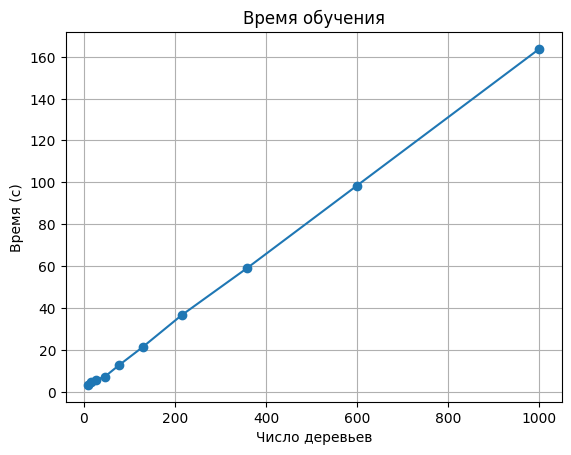

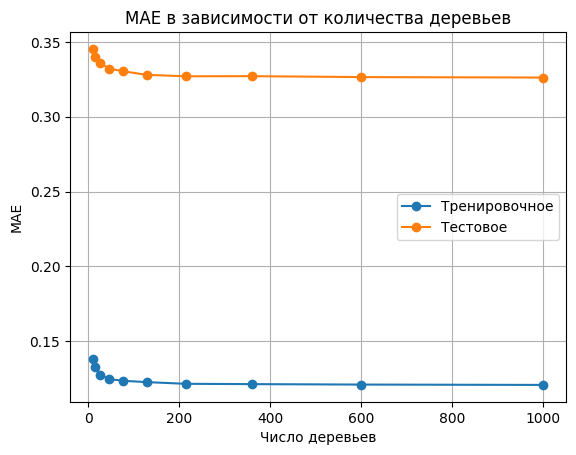

In [ ]:
n_trees = np.floor(np.logspace(1, 3, num=10)).astype(int)
train_mae, test_mae, times = [], [], []

for n in n_trees:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    start = time.time()
    model.fit(X_train, y_train)
    times.append(time.time() - start)

    train_mae.append(mean_absolute_error(y_train, model.predict(X_train)))
    test_mae.append(mean_absolute_error(y_test, model.predict(X_test)))

plt.plot(n_trees, times, marker='o')
plt.xlabel('Число деревьев')
plt.ylabel('Время (с)')
plt.title('Время обучения')
plt.grid()
plt.show()

plt.plot(n_trees, train_mae, marker='o', label='Тренировочное')
plt.plot(n_trees, test_mae, marker='o', label='Тестовое')
plt.xlabel('Число деревьев')
plt.ylabel('MAE')
plt.title('MAE в зависимости от количества деревьев')
plt.legend()
plt.grid()
plt.show()

**<font color='MediumOrchid'>Вывод по результату</font>**:

Время обучения растёт пропорционально числу деревьев (деревья обучаются независимо), поэтому придётся балансировать между качеством модели и её вычислительными затратами.

Большее количество деревьев уменьшает ошибку, но после ~200 деревьев качество предсказаний почти не меняется. Так же при большом количестве деревьев модель может переобучаться, так как разница между MAE на обучающей и тестовой выборке увеличивается.

----

Как мы с вами знаем, случайный лес постепенно улучшает качество предсказаний, увеличивая число деревьев в ансамбле. А что если мы уже обучили лес, но хотим `нарастить` его, добавив несколько деревьев? Или если к нам пришли новые данные и мы хотим добавить деревьев, обученных на них, но не удалять деревья, построенные на предыдущих данных? Такой трюк возможен, и для этого следует использовать warm_start. То, как правильно использовать `warm_start` можно глянуть [тут](https://stackoverflow.com/questions/42757892/how-to-use-warm-start/42763502)

### <font color='DarkOrange'>**Задание 1.4 [2 балла]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Создайте случайный лес со следующими параметрами: `n_estimators = 100, warm_start = True, random_state=42`
2. Обучите полученный лес, засекая время, потраченное на обучение, и измерив качество предсказания на тесте по MAE
3. Увеличьте число деревьев в лесу. Для этого увеличьте число `regressor.n_estimators` на 100.
4. Воспользуйтесь методом `fit`, чтобы дообучить новые деревья. Не забудьте замерить время и качество!
5. Повторяйте два предыдущих шага до тех пор, пока вы не вырастите лес с 1000 деревьями.
6. Постройте графики зависимости качества и времени обучения от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)
7. Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

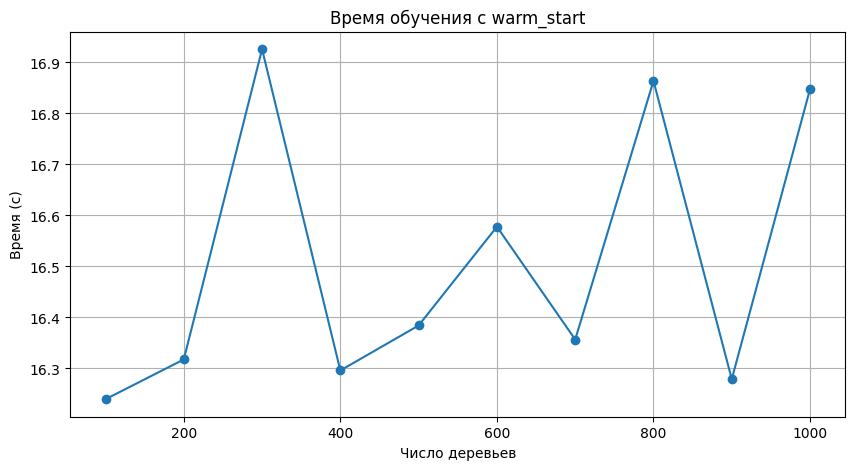

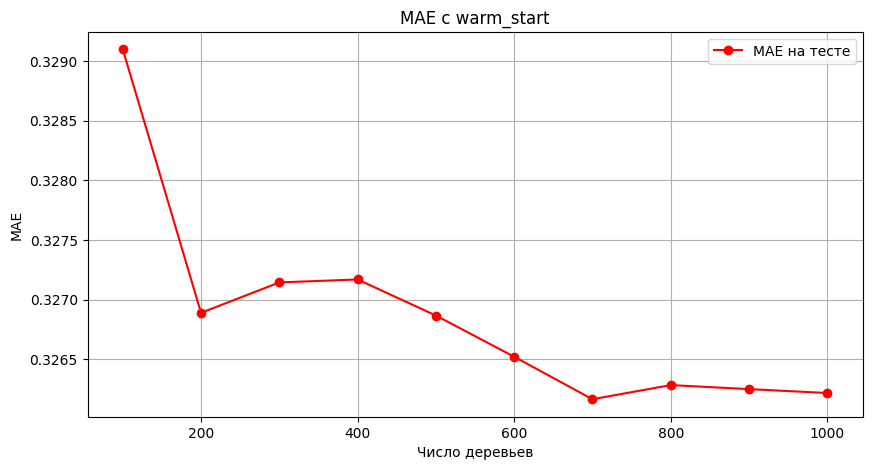

In [ ]:
n_trees_list = list(range(100, 1100, 100))
times, test_mae = [], []

random_forest_regressor = RandomForestRegressor(n_estimators=100, warm_start=True, random_state=42)
for n_trees in n_trees_list:
    start_time = time.time()
    random_forest_regressor.n_estimators = n_trees
    random_forest_regressor.fit(X_train, y_train)
    times.append(time.time() - start_time)
    test_mae.append(mean_absolute_error(y_test, random_forest_regressor.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, times, marker='o')
plt.xlabel('Число деревьев')
plt.ylabel('Время (с)')
plt.title('Время обучения с warm_start')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, test_mae, marker='o', color='red', label='MAE на тесте')
plt.xlabel('Число деревьев')
plt.ylabel('MAE')
plt.title('MAE с warm_start')
plt.legend()
plt.grid()
plt.show()

**<font color='MediumOrchid'>Вывод по результату</font>**:

Время обучения колеблется, хотя в целом остаётся на одном уровне (~16.5–17 сек).

MAE снижается по мере увеличения числа деревьев, но делает это неравномерно. Качество растёт, но после 600-800 деревьев улучшения минимальны.  

# Отбор признаков

Теперь переключимся на несколько иную задачу. Представим, что нам нужно не только обучить какой-то метод, но и выделить наиболее полезные признаки (или, как минимум, удалить шумовые). Как мы можем это сделать? На самом деле, в машинном обучении есть просто огромное количество способов отбора признаков, и сейчас мы познакомимся с самимы популярными из них.

### L1 регуляризация

Как вы уже узнали из лекций, регуляризация помогает делать процесс обучения более робастным. Однако у L1 регуляризации есть один побочный эффект - она также способна занулять наименее информативные признаки. Давайте проверим этот эффект на практике.

### <font color='DarkOrange'>**Задание 2.1 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучите три линейных классификатора с L1 регуляризацией (`linear_model.Lasso`). Установите коэффициенты регуляризации `alpha` равными `0.1, 0.2 и 0.5.` Перед подачей признаков в Lasso, `нормализуйте признаки` (MinMax или StandardScaler на ваш выбор).
1. Обучите данные классификаторы на обучающем множестве.
1. Замерьте их качество на тесте, а также выведите количество ненулевых коэффициентов. Коэффициенты обученной линейной регрессии можно получить при помощи аттрибута `.coef_`
1. Выведите признаки, которые были занулены. Имена признаков можно найти в fetch_california_housing().feature_names
1. Сделайте выводы о способности LASSO отбирать признаки

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso

feature_names = fetch_california_housing().feature_names

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.1, 0.2, 0.5]
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)

    num_nonzero = np.sum(model.coef_ != 0)
    zero_features = [feature_names[i] for i in range(len(model.coef_)) if model.coef_[i] == 0]

    print(f"Alpha = {alpha}")
    print(f"MAE: {mae:.4f}")
    print(f"Ненулевых коэффициентов: {num_nonzero}")
    print(f"Зануленные признаки: {zero_features}\n")

print(f"Все признаки: {feature_names}")

Alpha = 0.1
MAE: 0.8920
Ненулевых коэффициентов: 1
Зануленные признаки: ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Alpha = 0.2
MAE: 0.9100
Ненулевых коэффициентов: 0
Зануленные признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Alpha = 0.5
MAE: 0.9100
Ненулевых коэффициентов: 0
Зануленные признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Все признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


**<font color='MediumOrchid'>Вывод по результату</font>**:

При alpha = 0.1 только один признак остался ненулевым — MedInc (доход населения). Остальные признаки занулились.

При alpha = 0.2 и alpha = 0.5 все признаки занулились, оставив только константный прогноз.

Таким образом, LASSO может использоваться для отбора признаков, оставляя только самые важные, но с увеличением alpha предсказание модели может стать константным.

Отлично! Мы убедились, что при помощи L1 регуляризации можно отбирать наиболее информативные признаки. Такой же трюк можно применять к svm, который может занулить признак, если ни один опорный объект не использует его.

Как мы помним, при помощи линейных классификаторов можно ранжировать признаки по важности, воспользовавшись соответствующими коэффициентами. Но перед этим нужно нормализовать используемые признаки, иначе значения коэффициентов невозможно будет сравнивать между собой.

Мы не зря начали данное задание со случайных лесов. Случайные леса также могут оценивать важность признаков! У каждого обученного леса есть аттрибут `feature_importances_.` Эти оценки рассчитываются на основе уменьшения критерия качества (например, Джини для классификации или среднеквадратичной ошибки для регрессии) при разделении узлов дерева на основе каждого признака. Чем сильнее увеличивается качество при использовании признака - тем он важнее.

 Данные значения уже отнормализованы и их можно использовать в явном виде для оценки важности признаков! Давайте воспользуемся этим.

### <font color='DarkOrange'>**Задание 2.2 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучите один случайный лес, установив`n_estimators=100`.
1. При помощи `rf.feature_importances_` найдите три признака, которые являются наиболее важными, а также три наименее важных признака. Выведите их названия.
1. Обучите обычную линейную регрессию `LinearRegressio`n на всех признаках, а также только на отобранных случайными лесами признаках. Не забывайте, что перед использованием линейной регрессии признаки нужно `отнормализовать`!

1. Сравните качество предсказаний и сделайте вывод о качестве выделенных признаков. Сравните с признаками, выделенными через LASSO.

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)

top_features = [feature_names[i] for i in sorted_indices[-3:]]
low_features = [feature_names[i] for i in sorted_indices[:3]]

print(f"Лучшие 3 признака: {top_features}")
print(f"Худшие 3 признака: {low_features}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_all = LinearRegression().fit(X_train_scaled, y_train)
mae_all = mean_absolute_error(y_test, lr_all.predict(X_test_scaled))

top_indices = sorted_indices[-3:]
X_train_top = X_train_scaled[:, top_indices]
X_test_top = X_test_scaled[:, top_indices]

lr_top = LinearRegression().fit(X_train_top, y_train)
mae_top = mean_absolute_error(y_test, lr_top.predict(X_test_top))

print(f"MAE (все признаки): {mae_all:.4f}")
print(f"MAE (только 3 лучших признака): {mae_top:.4f}")

Лучшие 3 признака: ['Latitude', 'AveOccup', 'MedInc']
Худшие 3 признака: ['AveBedrms', 'Population', 'AveRooms']
MAE (все признаки): 0.5297
MAE (только 3 лучших признака): 0.6209


**<font color='MediumOrchid'>Вывод по результату</font>**:

MAE на всех признаках меньше, чем на трёх лучших. Лучшие 3 признака, найденные случайным лесом, не дали более точных предсказаний в линейной регрессии. Это может быть связано с тем, что случайный лес и линейная регрессия работают по-разному: случайный лес может учитывать сложные нелинейные зависимости, а линейная регрессия – только линейные.

---

До сих пор мы отбирали признаки по принципу удаления наименее информативных. Однако к данной задаче можно подойти с другого конца - добавлять признаки по 1, выбирая наиболее информативный из тех, что мы еще не использовали. Давайте посмотрим, что мы получим при помощи такой стратегии.

Кратко, данную стратегию можно описать следующим псевдокодом:

1. Инициализировать список выбранных признаков (пустой)  
2. Инициализировать список оставшихся признаков (все доступные)  
3. Пока выбранное число признаков меньше необходимого:  
   3.1 Для каждого признака из оставшихся:  
      - Добавить его к текущему списку выбранных  
      - Обучить модель на этих признаках  
      - Вычислить ошибку на тестовых данных  
      
   3.2 Добавить признак с наименьшем значением ошибки в пункте 3.1 в список выбранных

   3.3 Удалить его из списка оставшихся  

4. Вернуть список лучших признаков  


### <font color='DarkOrange'>**Задание 2.3 [2 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Реализуйте процесс отбора признаков путем добавление одного наиболее информативного признака. Воспользуйтесь `DecisionTreeRegressor` в качестве базового классификатора.
1. Отберите 3 наиболее важных признака
1. Обучите обычную линейную регрессию на всех признаках, а также только на отобранных признаках. Сравните качество предсказаний и сделайте вывод о качестве выделенных признаков. Сравните с признаками, выделенными в предыдущем задании.

In [ ]:
def select_best_features(X_train, X_test, y_train, y_test, max_features=3):
    best_features = []
    remaining_features = list(range(X_train.shape[1]))
    best_mae = float("inf")

    for _ in range(max_features):
        best_feature = None
        for feature in remaining_features:
            selected_features = best_features + [feature]
            model = DecisionTreeRegressor(random_state=42)
            model.fit(X_train[:, selected_features], y_train)
            y_pred = model.predict(X_test[:, selected_features])
            mae = mean_absolute_error(y_test, y_pred)

            if mae < best_mae:
                best_mae = mae
                best_feature = feature

        if best_feature is not None:
            best_features.append(best_feature)
            remaining_features.remove(best_feature)

    return best_features

In [ ]:
best_features = select_best_features(X_train, X_test, y_train, y_test)

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

lr_all = LinearRegression()
lr_all.fit(X_train, y_train)
y_pred_all = lr_all.predict(X_test)
mae_all = mean_absolute_error(y_test, y_pred_all)

lr_selected = LinearRegression()
lr_selected.fit(X_train.iloc[:, best_features], y_train)
y_pred_selected = lr_selected.predict(X_test.iloc[:, best_features])
mae_selected = mean_absolute_error(y_test, y_pred_selected)

print(f"MAE на всех признаках: {mae_all:.4f}")
print(f"MAE на отобранных признаках: {mae_selected:.4f}")
print(f"Отобранные признаки: {best_features}")

MAE на всех признаках: 0.5297
MAE на отобранных признаках: 0.7664
Отобранные признаки: [7, 6]


**<font color='MediumOrchid'>Вывод по результату</font>**:

MAE на всех признаках меньше, чем на отобранных признаках. Это означает, что линейная регрессия на всех признаках дает более точные предсказания, чем на отобранных. Выбранные признаки ([7, 6]) оказались недостаточными для точного предсказания. Возможно, DecisionTreeRegressor отобрал признаки, которые важны для него, но не так хорошо работают с линейной регрессией.